In [1]:
import csv
import datetime
import h5py
import keras
from keras import backend as K
import numpy as np
import os
import pandas as pd
import pescador
import pescador.maps
import random
import sys
import tensorflow as tf
import time

sys.path.append('../src')
import localmodule

# Define constants.
dataset_name = localmodule.get_dataset_name()
folds = localmodule.fold_units()
models_dir = localmodule.get_models_dir()
n_input_hops = 104
n_filters = [24, 48, 48, 96]
kernel_size = [5, 5]
pool_size = [2, 2]
n_hidden_units = 64
steps_per_epoch = 256
validation_steps = 256
batch_size = 32
n_context_classes = 4
bg_duration = 1800


# Read command-line arguments.
args = ["original", "unit01", 0]
aug_kind_str = args[0]
unit_str = args[1]
trial_id = args[2]
trial_str = "trial-" + str(trial_id)


# Set number of epochs.
if aug_kind_str == "none":
    epochs = 64
else:
    epochs = 128


# Retrieve fold such that unit_str is in the test set.
fold = [f for f in folds if unit_str in f[0]][0]
test_units = fold[0]
training_units = fold[1]
validation_units = fold[2]

Using TensorFlow backend.


ImportError: No module named 'pescador.maps'

In [10]:
spec_input = keras.layers.Input(
    shape=(128, n_input_hops, 1), name="spec_input")

# Layer 1
spec_bn = keras.layers.normalization.BatchNormalization(
    name="spec_bn")(spec_input)
spec_conv1 = keras.layers.Convolution2D(n_filters[0], kernel_size,
    padding="same", kernel_initializer="he_normal",
    name="spec_conv1")(spec_bn)
spec_pool1 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool1")(spec_conv1)

# Layer 2
spec_conv2 = keras.layers.Convolution2D(n_filters[1], kernel_size,
    padding="same", kernel_initializer="he_normal",
    activation="relu", name="spec_conv2")(spec_pool1)
spec_pool2 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool2")(spec_conv2)

# Layer 3
spec_conv3 = keras.layers.Convolution2D(n_filters[2], kernel_size,
    padding="same", kernel_initializer="he_normal",
    activation="relu", name="spec_conv3")(spec_pool2)
spec_pool3 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool3")(spec_conv3)

# Layer 4
spec_conv4 = keras.layers.Convolution2D(n_filters[3], kernel_size,
    padding="same", kernel_initializer="he_normal",
    activation="relu", name="spec_conv4")(spec_pool3)
spec_pool4 = keras.layers.MaxPooling2D(
    pool_size=pool_size, name="spec_pool4")(spec_conv4)

# Layer 4
spec_reshape = keras.layers.Reshape((-1, 8),
    name="spec_reshape")(spec_pool4)


# Background channel.
# Input
bg_input = keras.layers.Input(
    shape=(128, 9), name="bg_input")

# Pool
bg_pool = keras.layers.AveragePooling1D(
    pool_size=4, name="bg_pool")(bg_input)

# Permute
bg_permute = keras.layers.Permute(
    (2, 1), name="bg_permute")(bg_pool)

# Conv
bg_conv = keras.layers.Conv1D(
    8, 1, kernel_initializer="he_normal",
    activation="relu", name="bg_conv")(bg_permute)

# Flatten
bg_flatten = keras.layers.Flatten(
    name="bg_flatten")(bg_conv)

# Weights (mixture of experts)
bg_experts = keras.layers.Dense(8,
    kernel_initializer="he_normal",
    activation="tanh",
    name="bg_experts")(bg_flatten)

# Transposed weights
bg_transposed = keras.layers.Reshape((1, 8),
    name="bg_transposed")(bg_experts)

# Bias (adaptive threshold)
bg_bias = keras.layers.Dense(1,
    name="adaptive_threshold", activation="sigmoid",
    use_bias=False)(bg_flatten)


# Combined channel.
# Element-wise multiplication
multiply = keras.layers.Multiply(
    name="multiply")([spec_reshape, bg_transposed])

# Transpose
multiply_transposed = keras.layers.Permute((2, 1),
    name="multiply_transposed")(multiply)

# Dense layer with weight sharing across eperts
dense_across_experts = keras.layers.Dense(64,
    activation="relu",
    name="dense_across_experts")(multiply_transposed)

# Transpose again
dense_across_experts_transposed = keras.layers.Permute((2, 1),
    name="dense_across_experts_transposed")(dense_across_experts)

# Mixture of experts
mixture_of_experts = keras.layers.Lambda(lambda x: K.sum(x, axis=2),
    name="mixture_of_experts")(dense_across_experts_transposed)

# Dropout
dropout = keras.layers.Dropout(0.5, name="dropout")(mixture_of_experts)

# Concatenation
concat = keras.layers.Concatenate(axis=1)([dropout, bg_bias])

# Event detection function
edf = keras.layers.Dense(1, activation="sigmoid", name="edf")(concat)

In [11]:
inputs = [spec_input, bg_input]
model = keras.models.Model(inputs=inputs, outputs=edf)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
spec_input (InputLayer)          (None, 128, 104, 1)   0                                            
____________________________________________________________________________________________________
spec_bn (BatchNormalization)     (None, 128, 104, 1)   4           spec_input[0][0]                 
____________________________________________________________________________________________________
spec_conv1 (Conv2D)              (None, 128, 104, 24)  624         spec_bn[0][0]                    
____________________________________________________________________________________________________
spec_pool1 (MaxPooling2D)        (None, 64, 52, 24)    0           spec_conv1[0][0]                 
___________________________________________________________________________________________

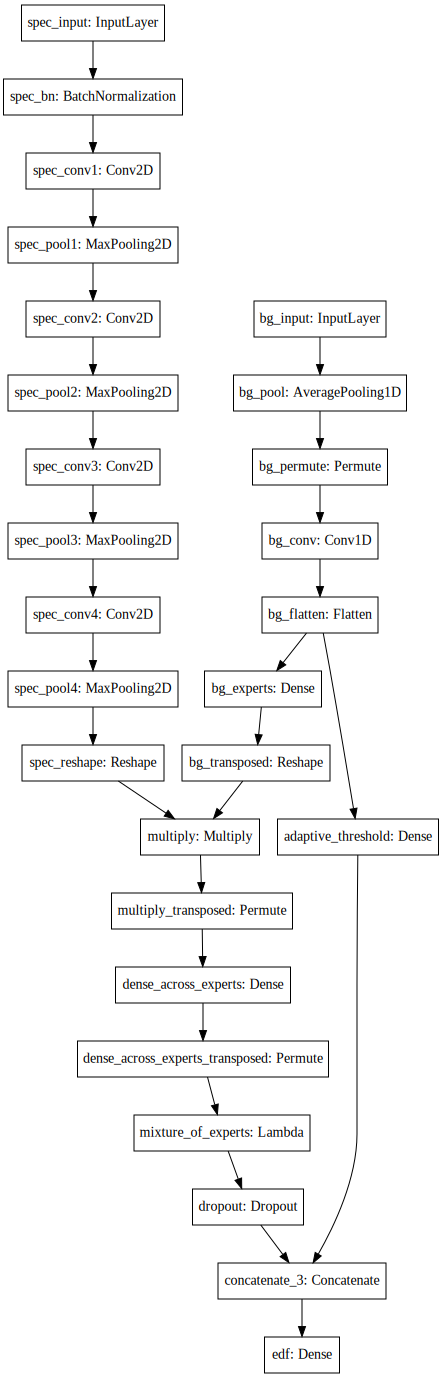

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

36864